<a href="https://colab.research.google.com/github/Rigved19/Covid-19-Prediction/blob/main/Covid_19_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

###**Importing Important Libraries for Data Preprcoessing**
* Numpy
* Pandas
* Enders, Normalizers, Standardizers
* Matplotlib

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt


###**Reading Data and Analysing**

In [ ]:
df = pd.read_csv("/content/covid-data (3).csv") #Reading the Data

In [ ]:
df.info() #Getting info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34873 entries, 0 to 34872
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         34809 non-null  object 
 1   continent                        34590 non-null  object 
 2   location                         34873 non-null  object 
 3   date                             34873 non-null  object 
 4   total_cases                      34532 non-null  float64
 5   new_cases                        34532 non-null  float64
 6   total_deaths                     34532 non-null  float64
 7   new_deaths                       34532 non-null  float64
 8   total_cases_per_million          34468 non-null  float64
 9   new_cases_per_million            34468 non-null  float64
 10  total_deaths_per_million         34468 non-null  float64
 11  new_deaths_per_million           34468 non-null  float64
 12  new_tests         

###**Condering Following features (10) :**
* Continent 
* Location 
* Date
* New Cases
* New Deaths
* Positive Rate
* Population Density
* Median Age
* Diabeters Prevelance
* Life Expectancy

In [ ]:
#Considering only relvant features(Columns)
df= df[["continent", "location" , "date" , "new_cases" , "new_deaths" , "positive_rate" , "population_density" , "median_age" , "diabetes_prevalence" , "life_expectancy" ]]

In [ ]:
df.isnull().sum()

continent                283
location                   0
date                       0
new_cases                341
new_deaths               341
positive_rate          23209
population_density      1584
median_age              3511
diabetes_prevalence     2432
life_expectancy          487
dtype: int64

###**Data Preprocessing :**

* Drop Null Value rows wrt "continent", "population density", "median age", "life expectancy", "diabetes prevalence"
* Drop "positive rate" column (due to many null values)
* Apply backfill for "new cases" and "new deaths"
* Converting Dates into Days



In [ ]:
#Data Preprocessing
df.dropna(subset = ["continent"] , inplace = True)  #Remove Null values corr to Coninent

df.drop(["positive_rate"] , axis = 1 , inplace = True)  # Drop Postive Rate Column
 #Remove Null values corr to following columns
df.dropna(subset = ["population_density" , "median_age" , "life_expectancy" ,  "diabetes_prevalence"] , inplace = True)

 #Apply before fill to New Cases and New Deaths
df["new_deaths"].fillna( method = "bfill" , inplace = True)
df["new_cases"].fillna( method = "bfill" , inplace = True)
df["continent"].astype("category")  #Only after changing it to category can we apply the encoding techniques
df["location"].astype("category")   #Only after changing it to category can we apply the encoding techniques

#Coverting date into Unifirm format
df["date"] = pd.to_datetime(df["date"])

# Converting dates into days
k = []
for x in df['date']:
  k.append((x-df["date"][0]).days)   #We have to convert into list and add seperatly into the Dataframe
                                     #since, we cant append directly into the dataframe, no method availbale like that
df["Day"] = k
df.info(210)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30564 entries, 0 to 34589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   continent            30564 non-null  object        
 1   location             30564 non-null  object        
 2   date                 30564 non-null  datetime64[ns]
 3   new_cases            30564 non-null  float64       
 4   new_deaths           30564 non-null  float64       
 5   population_density   30564 non-null  float64       
 6   median_age           30564 non-null  float64       
 7   diabetes_prevalence  30564 non-null  float64       
 8   life_expectancy      30564 non-null  float64       
 9   Day                  30564 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


###**Encoding Techniques**
* Label Encoding - "continent" (Due to less number, hierachy created is not an issue)
* Target Encoding - "location" wrt "new cases" (Creating correlation between location and cases in the location - self explanotory)

In [ ]:
#Feature Encoding
le = LabelEncoder()
te = TargetEncoder()
df["Continent_encoded"] = le.fit_transform(df["continent"])  #LabelEncoding for Continents
df["Location_encoded"] = te.fit_transform( df["location"] , df["new_cases"]) #TargetEncoding for Countries wrt New_Cases

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


###**Creating New Columns :**
* Prev Day Cases
* Prev Day Deaths

In [ ]:
#Calculating Previus Days Cases and Deaths
prev_day_cases = []
prev_day_cases.append(0)
for x in range(1 , df.shape[0]):
  if (df.iloc[x]["Location_encoded"] == df.iloc[x-1]["Location_encoded"]) :    #Use .iloc not .loc, since index are also deleted after deleting the rows
    prev_day_cases.append(df.iloc[x-1]["new_cases"])                           #As soon as Location changes, counter starts back from 0 cases for prev cases

  else :
    prev_day_cases.append(0)
df["Prev_Day_Cases"] = prev_day_cases   

#Calculating Previus Days Cases and Deaths
prev_day_deaths = []
prev_day_deaths.append(0)
for x in range(1 , df.shape[0]):
  if (df.iloc[x]["Location_encoded"] == df.iloc[x-1]["Location_encoded"]) :    #Use .iloc not .loc, since index are also deleted after deleting the rows
    prev_day_deaths.append(df.iloc[x-1]["new_deaths"])                         #As soon as Location changes, counter starts back from 0 cases for prev cases

  else :
    prev_day_deaths.append(0)  

df["Prev_Day_Deaths"] = prev_day_deaths

###**Sorting the entire dataset wrt :**
* Day (ie Day 0 of all countries will come first, then Day 1 and so on)
* Location (ie Day 0 of countries now to be aligned alphabetically)

In [ ]:
df.sort_values( by = ["Day" , "location"] , ascending =[True , True] , inplace = True ) #Sorting in ascending order wrt Days then, Location (Aplabeticallyl)
df["location"].astype("category")  #Returns the no. of countries

0        Afghanistan
359          Algeria
1303         Armenia
1649       Australia
1868         Austria
            ...     
33872      Venezuela
34091        Vietnam
34311          Yemen
34451         Zambia
34589       Zimbabwe
Name: location, Length: 30564, dtype: category
Categories (182, object): ['Afghanistan', 'Albania', 'Algeria', 'Angola', ..., 'Vietnam', 'Yemen',
                           'Zambia', 'Zimbabwe']

###**Train - Test Split**
* Dataset with "Day < 201" --> **Train**
* Dataset with "200 < Day < 218" ---> **Test**

In [ ]:
#Train Test Data Splitting
train_data = df[df["Day"] <= 200]  #df[Day] >= 200 returns Boolean Values to the condiction when fed to the entire data, passes only the rows corres. to values 
test_data = df[df['Day']>200]
test_data = test_data[test_data['Day']<218]
  #Same Logic
train_data = train_data.sample(frac=1) #Randomly shuffles entire training dataset
train_data.head(100)


,continent,location,date,new_cases,new_deaths,population_density,median_age,diabetes_prevalence,life_expectancy,Day,Continent_encoded,Location_encoded,Prev_Day_Cases,Prev_Day_Deaths
23695,Europe,Norway,2020-04-07,115.0,1.0,14.462,39.7,5.31,82.40,98,2,42.616438,130.0,8.0
12179,Europe,Germany,2020-03-28,6294.0,72.0,237.016,46.6,8.31,81.33,88,2,968.136986,5780.0,55.0
31956,Asia,Turkey,2020-03-23,289.0,9.0,104.914,31.6,12.13,77.69,83,1,1620.234483,277.0,12.0
23016,North America,Nicaragua,2020-04-21,0.0,1.0,51.667,27.3,11.47,74.48,112,3,27.871429,0.0,0.0
1791,Oceania,Australia,2020-05-21,11.0,1.0,3.202,37.9,5.07,83.44,142,4,85.520548,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20144,Europe,Malta,2020-02-18,1.0,0.0,1454.037,42.4,8.83,82.53,49,2,4.697802,1.0,0.0
24149,Asia,Pakistan,2020-05-04,1083.0,22.0,255.573,23.5,8.35,67.27,125,1,1313.719626,989.0,23.0
23152,Africa,Niger,2020-04-19,12.0,1.0,16.955,15.1,2.42,62.42,110,0,8.347826,18.0,3.0
11674,Africa,Gabon,2020-06-07,0.0,0.0,7.859,23.1,7.20,66.47,159,0,52.731034,146.0,0.0


###**Input Train :**
* Layer 1 (2) - "continent encoded" , "location encoded"
* Layer 2 (7) - "day" , "prev day cases" , "prev day deaths" , "population density" , "median age" , "diabetes prevelance" , "life expectancy"

###**Output Train :**
* Output Layer (2) - "new cases" ,"new deaths"


###**Input Test :**
* Layer 1 (2) - "continent encoded" , "location encoded"
* Layer 2 (6) - "prev day cases" , "prev day deaths" , "population density" , "median age" , "diabetes prevalence" , "life expectancy"

###**Output Test :**
* Output Layer (2) - "new cases" ,"new deaths"

In [ ]:
#Training Data into Input Features
#Input Layer 1  = 2 Features - Continent and Country (Location)
Xnet1_train = train_data[["Continent_encoded","Location_encoded"]] 

#Input Layer 2 = 7 features - Day , Prev Day Cases, Prev Day Deaths , Population Density , Median Age , Diabetes Prevelance , Life Expectaancy
Xnet2_train = train_data[["Day" , "Prev_Day_Cases" , "Prev_Day_Deaths" , "population_density" , "median_age" , "diabetes_prevalence" , "life_expectancy"]]

#Output Features (Target)
Ytrain = train_data[["new_cases" ,"new_deaths"]]

#Testing Data into Input Features
test_data=test_data[test_data['location']!='Hong Kong'] #Honk Kong has no data for new_cases, new_deaths
Xnet1_test = test_data[["Continent_encoded","Location_encoded"]] 
#Considering Days as a seperate entity for 
Xnet2_test = test_data[["Prev_Day_Cases" , "Prev_Day_Deaths" , "population_density" , "median_age" , "diabetes_prevalence" , "life_expectancy"]]
test_days = test_data["Day"].to_numpy()                                        #Conversion is importnat calculation can be done only with arrays not lists
Ytest = test_data[["new_cases" ,"new_deaths"]]

In [ ]:
#Training Feature Dimensions
print("Shape of Input features of Network1 " +str(Xnet1_train.shape))
print("Shape of Input features of Network2 " + str(Xnet2_train.shape))
print("Shape of Target of Network " + str(Ytrain.shape))
print(test_days.shape)

Shape of Input features of Network1 (27306, 2)
Shape of Input features of Network2 (27306, 7)
Shape of Target of Network (27306, 2)
(3077,)


###**Feature Scaling :**
* Normalization
* Standardization

In [ ]:
#Feature Scaling 
MinMax = MinMaxScaler(feature_range=(-10,10))
Standard = StandardScaler()
#Processing the Traning Data
#Normalizing Data -(Location_ Encoded, Continent_Encoded, Population Density , Median Age , Diabetes Prevelance , Life Expectancy between (-10 , 10)
#Net 1
Xnet1_train_scaled= MinMax.fit_transform(Xnet1_train) 

#Net2
Xnet2_train_scaled = Xnet2_train
Xnet2_train_scaled["population_density"] = MinMax.fit_transform(Xnet2_train["population_density"].to_numpy().reshape(-1,1))  #Need to reshape into 2D
Xnet2_train_scaled["median_age"] = MinMax.fit_transform(Xnet2_train["median_age"].to_numpy().reshape(-1,1))
Xnet2_train_scaled["diabetes_prevalence"] = MinMax.fit_transform(Xnet2_train["diabetes_prevalence"].to_numpy().reshape(-1,1))
Xnet2_train_scaled["life_expectancy"] = MinMax.fit_transform(Xnet2_train["life_expectancy"].to_numpy().reshape(-1,1))

#Standardize Data -( Prev_Day_Cases , Prev_Day_Deaths , Target )
Xnet2_train_scaled["Prev_Day_Cases"] = Standard.fit_transform(Xnet2_train["Prev_Day_Cases"].to_numpy().reshape(-1,1)) 
Xnet2_train_scaled["Prev_Day_Deaths"] = Standard.fit_transform(Xnet2_train["Prev_Day_Deaths"].to_numpy().reshape(-1,1))
Ytrain_scaled = Standard.fit_transform(Ytrain)                          
Xnet2_train_scaled = Xnet2_train_scaled.to_numpy()    #Calculation can be done only on arrays and not list

#Processing the Testing Data
Xnet1_test_scaled = MinMax.fit_transform(Xnet1_test)

Xnet2_test_scaled = Xnet2_test
Xnet2_test_scaled["population_density"] = MinMax.fit_transform(Xnet2_test["population_density"].to_numpy().reshape(-1,1))  #Need to reshape into 2D
Xnet2_test_scaled["median_age"] = MinMax.fit_transform(Xnet2_test["median_age"].to_numpy().reshape(-1,1))
Xnet2_test_scaled["diabetes_prevalence"] = MinMax.fit_transform(Xnet2_test["diabetes_prevalence"].to_numpy().reshape(-1,1))
Xnet2_test_scaled["life_expectancy"] = MinMax.fit_transform(Xnet2_test["life_expectancy"].to_numpy().reshape(-1,1))

Xnet2_test_scaled["Prev_Day_Cases"] = Standard.fit_transform(Xnet2_test["Prev_Day_Cases"].to_numpy().reshape(-1,1)) 
Xnet2_test_scaled["Prev_Day_Deaths"] = Standard.fit_transform(Xnet2_test["Prev_Day_Deaths"].to_numpy().reshape(-1,1))
Xnet2_test_scaled = Xnet2_test_scaled.to_numpy()

Ytest_scaled = Ytest
Ytest_scaled["new_cases"] = Standard.fit_transform(Ytest["new_cases"].to_numpy().reshape(-1,1))
Ytest_scaled["new_deaths"] = Standard.fit_transform(Ytest["new_deaths"].to_numpy().reshape(-1,1))
Ytest_scaled= Ytest_scaled.to_numpy()

t = Xnet2_test_scaled.T
p = t[:2,180:360]
print(p.shape)
#DataType
#Xnet1_train_scaled = nd.array
#Xnet2_train_scaled = nd.array
#Ytrain_scaled = nd.array

#Xnet1_test_scaled = nd.array
#Xnet2_test_scaled = nd.array
#Ytestscaled = nd.array
print(type(Ytest_scaled))

##**Multi Layer Perceptron**

####Functions being implemented are :
* Initialize Properties - No. of layers, No. of neurons in each layer, Activation Function used
* Initialize Parameters
* Forward Propogation
* Loss Function
* Backward Propogation
* Gradient Descent

In [ ]:
### Layers
class Layer:
    
    def __init__(self,no_layers,num_nodes:list,activation:list):
        self.layers=no_layers
        self.nodes=num_nodes
        self.activation=activation
        self.params=self.intialize_weight()
        self.grads={}

    def intialize_weight(self):
        np.random.seed(3)
        parameters = {}
        L = len(self.nodes)       

        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(self.nodes[l],self.nodes[l-1])*0.01
            parameters['b' + str(l)] = np.zeros((self.nodes[l],1))
            
            
        assert(parameters['W' + str(l)].shape == (self.nodes[l], self.nodes[l-1]))
        assert(parameters['b' + str(l)].shape == (self.nodes[l], 1))

        
        return parameters

### Activation

import numpy as np

class Activation:
    def Sigmoid(x,derivative=False):
        if derivative:
            return x-(x**2)
        else:
            return 1/(1+np.exp(-x))
    def Tanh(x,derivative=False):
        if derivative:
            return 1-(np.tanh(x)*np.tanh(x))
        else:
            return np.tanh(x)
    def Relu(x,derivative=False):
        if derivative:
            return np.greater(x,0).astype(float)
        else:
            return np.maximum(x,0)
    def Linear(x,derivative=False):
        if derivative:
            return 1
        else:
            return x

### Training

from matplotlib import pyplot as plt
import pickle


class MLP:

  def forward_propagate(self,net:Layer,X):
        net.params['a0']=X
        #Calculate the activations for every  layers
        for l in range(1, net.layers):
            net.params['z' + str(l)] = np.add(np.dot(net.params['W' + str(l)], net.params['a' + str(l - 1)]), net.params['b' + str(l)])
            if(net.activation[l-1]=='relu'):
                net.params['a' + str(l)] = Activation.Relu(net.params['z' + str(l)])
            elif(net.activation[l-1]=='tanh'):
                net.params['a' + str(l)] = Activation.Tanh(net.params['z' + str(l)])
            elif(net.activation[l-1]=='linear'):
                net.params['a' + str(l)] = Activation.Linear(net.params['z' + str(l)])
            else:
                net.params['a' + str(l)] = Activation.Sigmoid(net.params['z' + str(l)])
        return net
        
  def compute_cost(self,net, y):
        #compute the cost error
        m=y.shape[1]
        cost = 0.5/m *np.sum((y-net.params['a'+str(net.layers-1)])**2)
        cost=np.squeeze((cost))        
        return cost
    
  def compute_grads(self,net1,net2, y):
        #compuete gradiants
        L=net2.layers
        m=y.shape[1]
        net2.grads['dz' + str(L-1)] = net2.params['a' + str(L-1)] - y
        #dWlayers
        net2.grads['dW' + str(L-1)] = 1/m*np.dot(net2.grads['dz' + str(L-1)], net2.params['a' + str(L-2)].T)
        #dbL
        net2.grads['db' + str(L-1)] = 1/m*np.sum(net2.grads['dz' + str(L-1)],axis=1,keepdims=True)

        #Partial grads of the cost function with respect to z[layers], W[layers] and b[layers]
        for l in range(net2.layers-2, 0, -1):
            if(net2.activation[l-1]=='relu'):
                net2.grads['dz' + str(l)] = np.dot(np.transpose(net2.params['W' + str(l + 1)]), net2.grads['dz' + str(l + 1)])*Activation.Relu(net2.params['z' + str(l)],derivative=True)
            elif(net2.activation[l-1]=='tanh'):
                net2.grads['dz' + str(l)] = np.dot(np.transpose(net2.params['W' + str(l + 1)]), net2.grads['dz' + str(l + 1)])*Activation.Tanh(net2.params['z' + str(l)],derivative=True)
            elif(net2.activation[l-1]=='linear'):
                net2.grads['dz' + str(l)] = np.dot(np.transpose(net2.params['W' + str(l + 1)]), net2.grads['dz' + str(l + 1)])*Activation.Linear(net2.params['z' + str(l)],derivative=True)
            else:
                net2.grads['dz' + str(l)] = np.dot(np.transpose(net2.params['W' + str(l + 1)]), net2.grads['dz' + str(l + 1)])*Activation.Sigmoid(net2.params['z' + str(l)],derivative=True)
            net2.grads['dW' + str(l)] = 1/m * (np.dot(net2.grads['dz' + str(l)], np.transpose(net2.params['a' + str(l - 1)])))
            net2.grads['db' + str(l)] = 1 /m * (np.sum(net2.grads['dz'+str(l)],axis = 1,keepdims = True))
        #compute the gradient of network1 through network 2
        weight_2_1=net2.params['W1'][:,0:net1.nodes[-1]]
        if(net1.activation[0]=='relu'):
            net1.grads['dz1']=np.dot(weight_2_1.T,net2.params['z1'])*Activation.Relu(net1.params['z1'],derivative=True)
        elif(net1.activation[0]=='tanh'):
            net1.grads['dz1']=np.dot(weight_2_1.T,net2.params['z1'])*Activation.Tanh(net1.params['z1'],derivative=True)
        elif(net1.activation[0]=='linear'):
            net1.grads['dz1']=np.dot(weight_2_1.T,net2.params['z1'])*Activation.Linear(net1.params['z1'],derivative=True)
        else:
            net1.grads['dz1']=np.dot(weight_2_1.T,net2.params['z1'])*Activation.Relu(net1.params['z1'],derivative=True)
        net1.grads['dW1']=1/m * np.dot(net1.grads['dz1'], np.transpose(net1.params['a0']))
        net1.grads['db1']=1 / m * (np.sum(net1.grads['dz1'],axis = 1,keepdims = True))
        pass
    
  def update_params(self,net,lr1):
        
        for l in range(1, net.layers):
            net.params['W' + str(l)] -= lr1*net.grads['dW' + str(l)]
            net.params['b' + str(l)] -= lr1*net.grads['db' + str(l)]
        pass
        
      
  def saveweight(self,net1,net2):
    params=[net1,net2]
    with open('weights.dat','wb') as f:
        pickle.dump(params,f)
    print('weights saved successfully')
    pass

  def Train(self , X,Xnet2,Y,net1,net2,epochs,lr1,lr2,printcost):
    m=X.shape[1]
    costs=[]
    for i in range(0,epochs):
        
        net1=model.forward_propagate(net1,X)
        prop=np.concatenate([net1.params['a1'],Xnet2])
        net2=model.forward_propagate(net2,prop)
        cost=model.compute_cost(net2,Y)
        costs.append(cost)
        model.compute_grads(net1,net2,Y)
        if(i<epochs/2):
            model.update_params(net1,lr1)
        model.update_params(net2,lr2)

        if printcost and i % 100 == 0:
            costs.append(cost)
            print('cost %d :' %i + str(cost))
        
     # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Trainingloss")
    plt.show()
    model.saveweight(net1,net2)
    pass  
  
  def Predict(self, X,Xnet2,net1,net2):
    #predict with the cross validation set
    net_1=model.forward_propagate(net1,X)
    prop=np.concatenate([net_1.params['a1'],Xnet2])
    net_2=model.forward_propagate(net2,prop)
    return net2.params['a'+str(net2.layers-1)]

  def Test(self, X,X_net2,test_days,net1,net2):
    #evaluation function to test with test set
    y=np.zeros((2,X_net2.shape[1]))
    m=X.shape[1]
    i=1
    size=180 #number of countries
    while(i<17):   #17 days are in test set
        X_test_batch_net1=X[:,(i-1)*size:i*size]
        X_test_batch_net2=X_net2[:,(i-1)*size:i*size]
        test_day=test_days[:,(i-1)*size:i*size]
        X_test_batch_net2 =np.concatenate([test_day,X_test_batch_net2])
        net_1=model.forward_propagate(net1, X_test_batch_net1)
        prop=np.concatenate([net_1.params['a1'],X_test_batch_net2])
        net_2=model.forward_propagate(net2,prop)
        y[:,(i-1)*size:i*size]=net_2.params['a'+str(net_2.layers-1)]
        X_net2[:2,i*size:(i+1)*size]=y[:,(i-1)*size:i*size]
        i+=1
        
    return y


  
  
model=MLP()    #model is an object of class MLP
### Load Model

class loadmodel :
  def load_weights():
    with open('weights.dat','rb') as f:
        weights = pickle.load(f)
        net1,net2=weights[0],weights[1]
    return net1,net2




cost 0 :0.9999906328654365
cost 100 :0.9999568900520545
cost 200 :0.9998718156918861
cost 300 :0.9997368103619825
cost 400 :0.9994237376762887
cost 500 :0.9985944940636158
cost 600 :0.9954143098086539
cost 700 :0.9725110401011012
cost 800 :0.7363111103170014
cost 900 :0.49067840264830914
cost 1000 :0.47895140178551093
cost 1100 :0.46814247652738084
cost 1200 :0.45654036765904693
cost 1300 :0.4433281948931976
cost 1400 :0.4279558313749064


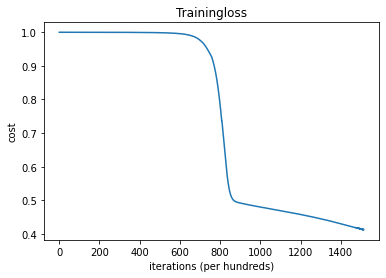

weights saved successfully


In [ ]:
#Training the model
NeuralNet1 = Layer(2,[2,5],activation=['linear'])
NeuralNet2 = Layer(4,[12,16,16,2],activation=['relu','relu','linear'])
epochs=1500
lr1=0.1
lr2=0.005
model.Train(Xnet1_train_scaled.T, Xnet2_train_scaled.T, Ytrain_scaled.T, NeuralNet1, NeuralNet2, epochs, lr1, lr2, printcost=True)
trainedNet1,trainedNet2 = loadmodel.load_weights()

In [ ]:
Ypred = model.Predict(Xnet1_train_scaled.T, Xnet2_train_scaled.T, trainedNet1, trainedNet2)

In [ ]:
print('TRAINING LOSS :'+str((mse(Ypred.T,Ytrain_scaled))))

TRAINING LOSS :0.41167715185925413


In [ ]:
#Using model weights for test cases
test_days=test_days.reshape(1,test_days.shape[0])
Ypred_test = model.Test(Xnet1_test_scaled.T, Xnet2_test_scaled.T, test_days, trainedNet1, trainedNet2)

In [ ]:

#Loss for Test Cases
print('TEST LOSS : ' + str(mse(Ypred_test,Ytest_scaled.T)))


TEST LOSS : 0.9584656663685227
